In [2]:
# Görselleştirme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# İstatistiksel işlemler 
from scipy import stats
from scipy.stats import randint

# Veri bölme ve ön işleme için gerekli kütüphaneler
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.preprocessing import binarize, LabelEncoder  

# Makine öğrenimi modelleri
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 

# Performans değerlendirme ve metrikler
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score  


In [3]:
data = pd.read_csv('survey.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [5]:
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

In [6]:
# Veri setindeki eksik değerleri (NaN) belirli bir varsayılan değerle doldurma
for feature in data:
    if feature in intFeatures:
        data[feature] = data[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        data[feature] = data[feature].fillna(defaultString)
    elif feature in floatFeatures:
        data[feature] = data[feature].fillna(defaultFloat)
    else:
        print('Error: öznitelik %s tanınmıyor.' % feature)

data.head()

Error: öznitelik Timestamp tanınmıyor.
Error: öznitelik state tanınmıyor.
Error: öznitelik comments tanınmıyor.


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [7]:
# Gender verisini gruplama 
gender = data['Gender'].str.lower()
gender = data['Gender'].unique()

male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", 
            "mail", "malr","cis man", "Cis Male", "cis male"]

trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", 
             "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", 
             "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", 
             "ostensibly male, unsure what that really means"]

female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", 
              "female (cis)", "femail"]

In [8]:
for (row, col) in data.iterrows():
    if str.lower(col.Gender) in male_str:
        data['Gender'].replace(to_replace = col.Gender, value = 'male', inplace = True)

    if str.lower(col.Gender) in trans_str:
        data['Gender'].replace(to_replace = col.Gender, value = 'others', inplace = True)

    if str.lower(col.Gender) in female_str:
        data['Gender'].replace(to_replace = col.Gender, value = 'female', inplace = True)

random_list = ['A little about you', 'p']
data = data[~data['Gender'].isin(random_list)]

In [9]:
print(data['Gender'].unique())

['female' 'male' 'others']


In [10]:
# Eksik geçersiz yaş verilerini medyan ile doldurma
if data['Age'].isna().all():
    raise ValueError("Age sütununda yalnızca eksik değerler var. Medyan hesaplanamaz.")
else:
    # NaN değerleri medyan ile doldurma
    data['Age'] = data['Age'].fillna(data['Age'].median())  # inplace kullanmadan atama

median_age = data['Age'].median()
data['Age'] = data['Age'].apply(lambda x: median_age if x < 18 or x > 120 else x)

# Yaşı aralıklara bölme
bins = [0, 20, 30, 65, 100]
labels = ["0-20", "21-30", "31-65", "66-100"]
data['age_range'] = pd.cut(data['Age'], bins=bins, labels=labels, include_lowest=True)


In [11]:
data['self_employed'] = data['self_employed'].replace([defaultString], 'No')
print(data['self_employed'].unique())

['No' 'Yes']


In [12]:
data['work_interfere'] = data['work_interfere'].replace([defaultString], 'Don\'t know')
print(data['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


In [13]:
data['Gender'].unique()

array(['female', 'male', 'others'], dtype=object)

In [14]:
data['Age'].unique()

array([37., 44., 32., 31., 33., 35., 39., 42., 23., 29., 36., 27., 46.,
       41., 34., 30., 40., 38., 50., 24., 18., 28., 26., 22., 19., 25.,
       45., 21., 43., 56., 60., 54., 55., 48., 20., 57., 58., 47., 62.,
       51., 65., 49., 53., 61., 72.])

In [15]:
data['family_history'].unique()

array(['No', 'Yes'], dtype=object)

In [16]:
data['work_interfere'].unique()

array(['Often', 'Rarely', 'Never', 'Sometimes', "Don't know"],
      dtype=object)

In [17]:
data.drop(['Timestamp', 'Country', 'state','comments'], axis=1, inplace=True)

In [18]:
# Label Encoding
labelDict = {}
for feature in data:
    le = preprocessing.LabelEncoder()
    le.fit(data[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    data[feature] = le.transform(data[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [19]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()
print(missing_data)

                           Total  Percent
Age                            0      0.0
Gender                         0      0.0
obs_consequence                0      0.0
mental_vs_physical             0      0.0
phys_health_interview          0      0.0
mental_health_interview        0      0.0
supervisor                     0      0.0
coworkers                      0      0.0
phys_health_consequence        0      0.0
mental_health_consequence      0      0.0
leave                          0      0.0
anonymity                      0      0.0
seek_help                      0      0.0
wellness_program               0      0.0
care_options                   0      0.0
benefits                       0      0.0
tech_company                   0      0.0
remote_work                    0      0.0
no_employees                   0      0.0
work_interfere                 0      0.0
treatment                      0      0.0
family_history                 0      0.0
self_employed                  0  

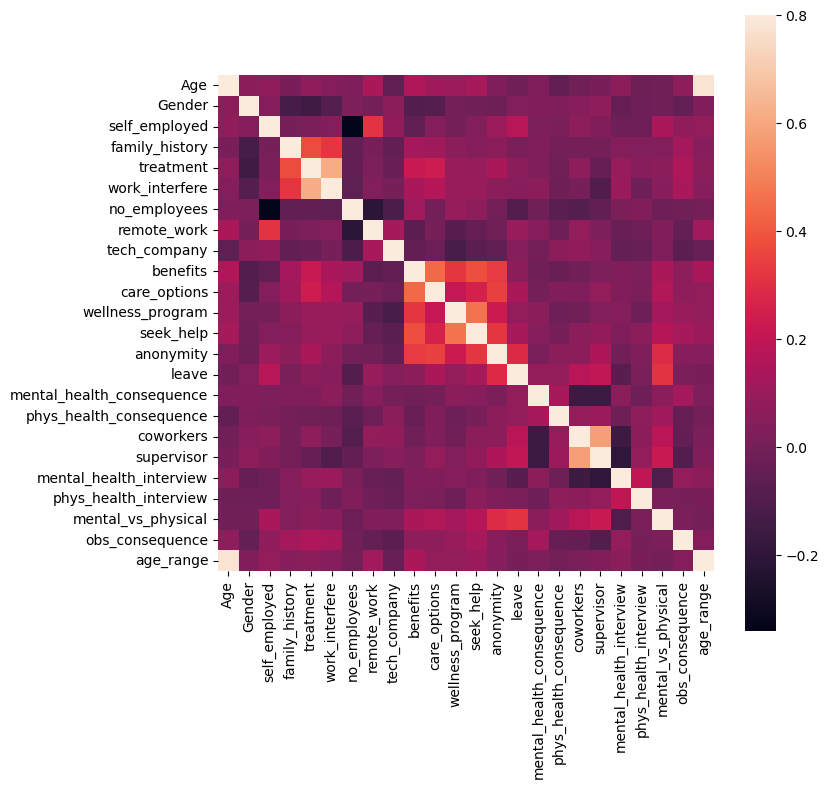

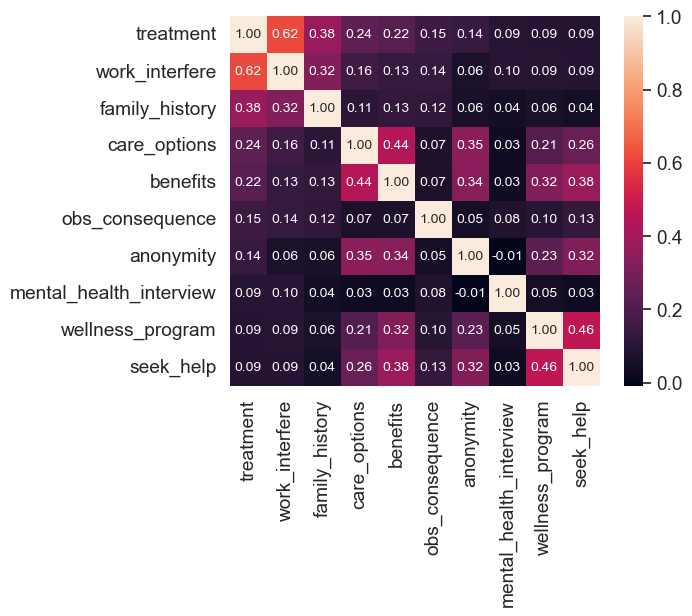

In [20]:
# Korelasyon Matrisleri

# özniteliklerin korelasyonu
corrmat = data.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment korelasyon matrisi
k = 10
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Text(0.5, 0, 'Yaş')

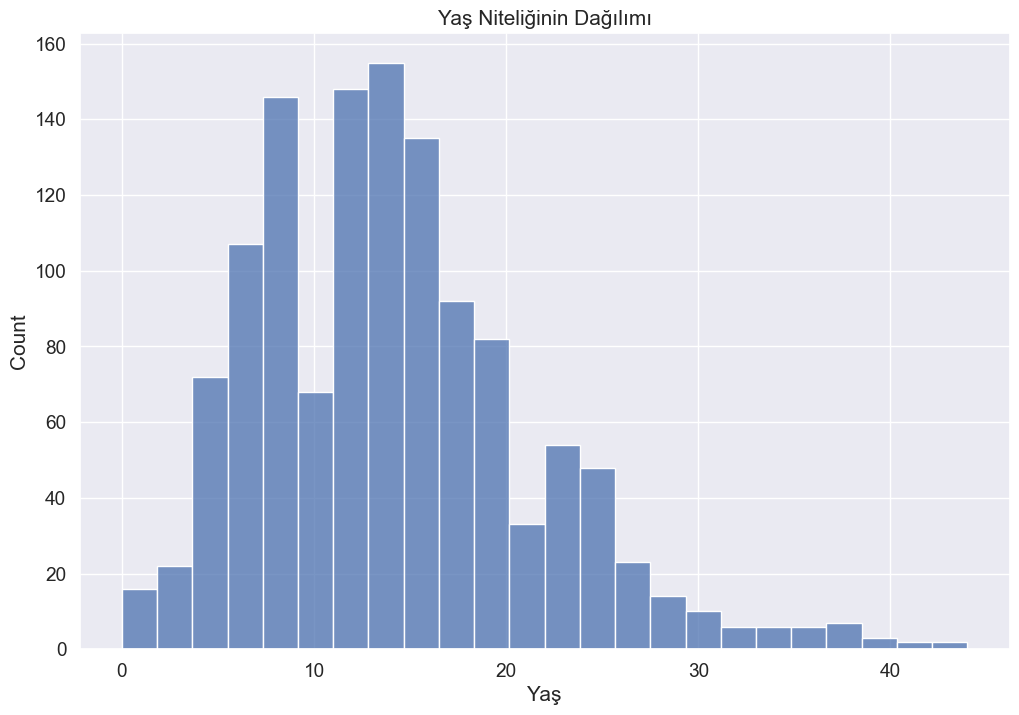

In [21]:
plt.figure(figsize=(12,8))
sns.histplot(data["Age"], bins=24)
plt.title("Yaş Niteliğinin Dağılımı")
plt.xlabel("Yaş")

In [22]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1257 entries, 0 to 1258
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Age                        1257 non-null   int64
 1   Gender                     1257 non-null   int32
 2   self_employed              1257 non-null   int32
 3   family_history             1257 non-null   int32
 4   treatment                  1257 non-null   int32
 5   work_interfere             1257 non-null   int32
 6   no_employees               1257 non-null   int32
 7   remote_work                1257 non-null   int32
 8   tech_company               1257 non-null   int32
 9   benefits                   1257 non-null   int32
 10  care_options               1257 non-null   int32
 11  wellness_program           1257 non-null   int32
 12  seek_help                  1257 non-null   int32
 13  anonymity                  1257 non-null   int32
 14  leave                      12

In [23]:
feature_cols = [  'Age', 'Gender', 'family_history', 'work_interfere', 'benefits', 'care_options', 
                      'no_employees', 'leave', 'coworkers', 'supervisor', 
                     'mental_health_interview']

X = data[feature_cols]
y = data.treatment

# Hold-out yöntemiyle train ve test verisinin ayrılması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

methodDict = {} # Model ve değerlendirme metriklerinin tutulacağı dict 

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Model Değerlendirme Fonksiyonu
def evalClassModel(model, X_test, y_test, y_pred_class, plot=False):
    # Confusion matrix hesapla
    confusion = metrics.confusion_matrix(y_test, y_pred_class)

    # Classification report yazdırma
    classification_report = metrics.classification_report(y_test, y_pred_class, target_names=["Negative", "Positive"])
    print("\nClassification Report:")
    print(classification_report)
    
    # Performans metriklerini hesapla
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    precision = metrics.precision_score(y_test, y_pred_class)
    recall = metrics.recall_score(y_test, y_pred_class)
    specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
    f1_score = metrics.f1_score(y_test, y_pred_class)
    false_positive_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])
    auc_score = metrics.roc_auc_score(y_test, y_pred_class)
    
    print(f"\nPerformance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # Çapraz doğrulama ile AUC puanı
    cross_val_auc = cross_val_score(model, X_test, y_test, cv=10, scoring='roc_auc').mean()
    print(f"Cross-validated AUC: {cross_val_auc:.4f}")
    
    # Confusion matrix'i görselleştirme
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion, annot=True, fmt="d", cmap='Blues', xticklabels=["Negative", "Positive"], 
                yticklabels=["Negative", "Positive"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC eğrisini çiz ve AUC skorunu yazdırma
    if plot:
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
        
        plt.figure(figsize=(4, 4))
        plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()

    # Performans metriklerini bir dictionary içinde döndür
    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1_score": f1_score,
        "false_positive_rate": false_positive_rate,
        "auc_score": auc_score,
        "cross_val_auc": cross_val_auc
    }
    
    return metrics_dict


########### Karar Ağaçları ###############

Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.68      0.78       191
    Positive       0.74      0.94      0.83       187

    accuracy                           0.81       378
   macro avg       0.83      0.81      0.80       378
weighted avg       0.83      0.81      0.80       378


Performance Metrics:
Accuracy: 0.8069
Precision: 0.7415
Recall (Sensitivity): 0.9358
Specificity: 0.6806
F1 Score: 0.8274
False Positive Rate: 0.3194
AUC Score: 0.8082
Cross-validated AUC: 0.8646


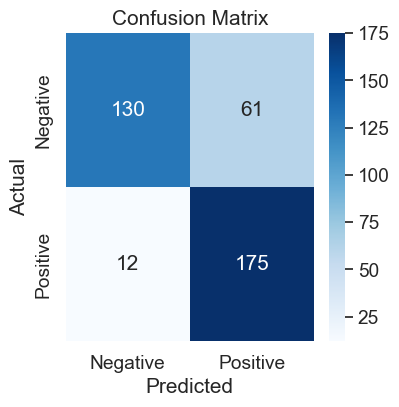

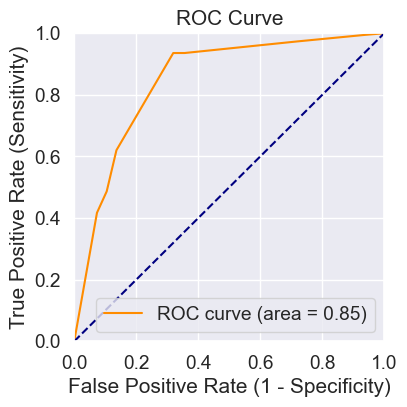

Model Accuracy stored in methodDict: 80.69%


In [25]:
# Karar Ağaçları modeli tanımlama
tree = DecisionTreeClassifier(
    max_depth=3, 
    min_samples_split=8, 
    max_features=6, 
    criterion='entropy', 
    min_samples_leaf=7
)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print('########### Karar Ağaçları ###############')

# Performans metriklerini al
metrics_results = evalClassModel(tree, X_test, y_test, y_pred, plot=True)


# methodDict güncelleme (örnek)
methodDict['Decision Tree'] = {key: value * 100 for key, value in metrics_results.items()}  # Tüm metrikleri yüzde olarak ekle
# Doğruluk değerini çekip yazdırma
print(f"Model Accuracy stored in methodDict: {methodDict['Decision Tree']['accuracy']:.2f}%")




########### Random Forest ###############

Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.75      0.83       191
    Positive       0.79      0.93      0.85       187

    accuracy                           0.84       378
   macro avg       0.85      0.84      0.84       378
weighted avg       0.85      0.84      0.84       378


Performance Metrics:
Accuracy: 0.8413
Precision: 0.7873
Recall (Sensitivity): 0.9305
Specificity: 0.7539
F1 Score: 0.8529
False Positive Rate: 0.2461
AUC Score: 0.8422
Cross-validated AUC: 0.8895


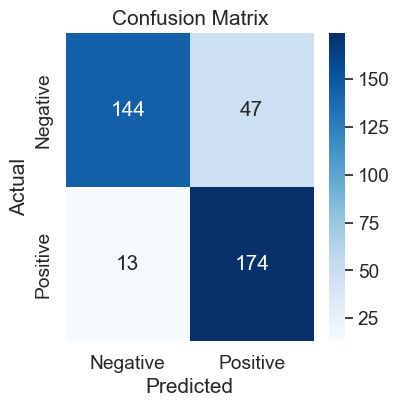

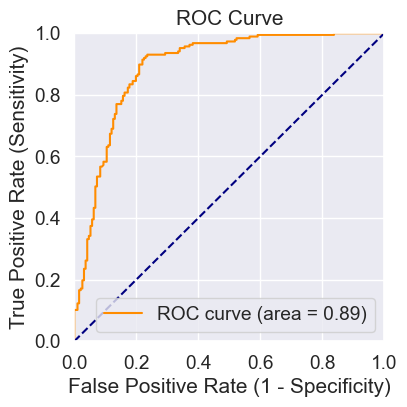

Model Accuracy stored in methodDict: 84.13%


In [41]:
# Random Forest Classifier
random_forest = RandomForestClassifier(
    max_depth=None, 
    min_samples_leaf=8, 
    min_samples_split=2, 
    n_estimators=20, 
    random_state=1
)

# Model eğitimi
forest = random_forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print('########### Random Forest ###############')

# Performans ölçümleri
metrics_results = evalClassModel(forest, X_test, y_test, y_pred, plot=True)
methodDict['R. Forest'] = {key: value * 100 for key, value in metrics_results.items()}  # Tüm metrikleri yüzde olarak ekle

print(f"Model Accuracy stored in methodDict: {methodDict['R. Forest']['accuracy']:.2f}%")



########### Naive Bayes Sınıflandırıcı ###############

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.79      0.81       191
    Positive       0.79      0.84      0.82       187

    accuracy                           0.81       378
   macro avg       0.82      0.82      0.81       378
weighted avg       0.82      0.81      0.81       378


Performance Metrics:
Accuracy: 0.8148
Precision: 0.7940
Recall (Sensitivity): 0.8449
Specificity: 0.7853
F1 Score: 0.8187
False Positive Rate: 0.2147
AUC Score: 0.8151
Cross-validated AUC: 0.8672


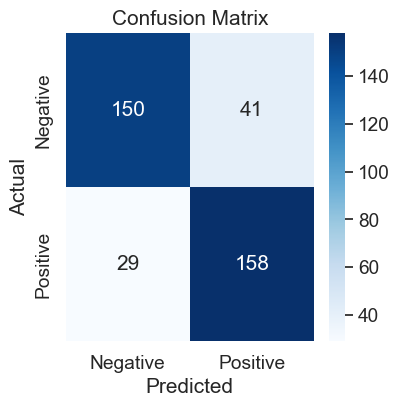

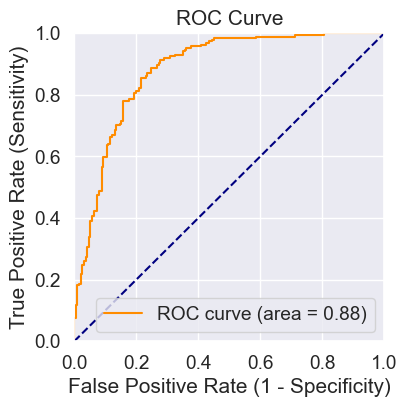

Model Accuracy stored in methodDict: 81.48%


In [27]:
# Naive Bayes Classifier
gnb = GaussianNB()

# Model eğitimi ve test tahminleri
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print('########### Naive Bayes Sınıflandırıcı ###############')

# Performans ölçümleri
metrics_results = evalClassModel(gnb, X_test, y_test, y_pred, plot=True)
methodDict['NB'] = {key: value * 100 for key, value in metrics_results.items()}  # Tüm metrikleri yüzde olarak ekle

print(f"Model Accuracy stored in methodDict: {methodDict['NB']['accuracy']:.2f}%")



Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
########### KNeighbors Sınıflandırıcı ###############

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.73      0.77       191
    Positive       0.75      0.84      0.79       187

    accuracy                           0.78       378
   macro avg       0.79      0.78      0.78       378
weighted avg       0.79      0.78      0.78       378


Performance Metrics:
Accuracy: 0.7831
Precision: 0.7512
Recall (Sensitivity): 0.8396
Specificity: 0.7277
F1 Score: 0.7929
False Positive Rate: 0.2723
AUC Score: 0.7837
Cross-validated AUC: 0.8499


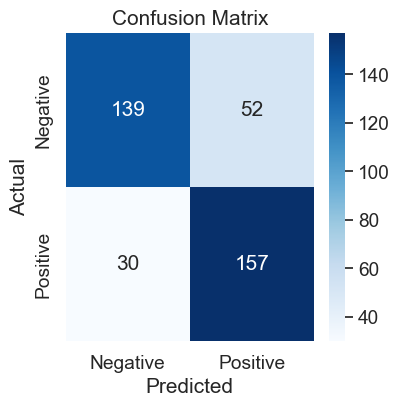

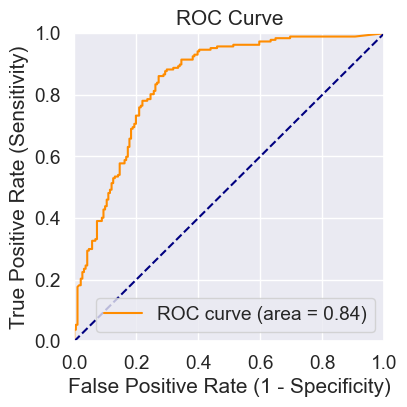

Model Accuracy stored in methodDict: 78.31%


In [97]:
# KNeighbors Classifier (GridSearch ile optimize edilmiş)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi model ve tahminler
best_knn = grid_search.best_estimator_
print("\nBest KNN Parameters:", grid_search.best_params_)

y_pred = best_knn.predict(X_test)

print('########### KNeighbors Sınıflandırıcı ###############')

# Performans ölçümleri
metrics_results = evalClassModel(best_knn, X_test, y_test, y_pred, plot=True)
methodDict['KNN'] = {key: value * 100 for key, value in metrics_results.items()}  # Tüm metrikleri yüzde olarak ekle

print(f"Model Accuracy stored in methodDict: {methodDict['KNN']['accuracy']:.2f}%")

########### Logistic Regression ###############

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.73      0.79       191
    Positive       0.76      0.88      0.82       187

    accuracy                           0.80       378
   macro avg       0.81      0.80      0.80       378
weighted avg       0.81      0.80      0.80       378


Performance Metrics:
Accuracy: 0.8042
Precision: 0.7628
Recall (Sensitivity): 0.8770
Specificity: 0.7330
F1 Score: 0.8159
False Positive Rate: 0.2670
AUC Score: 0.8050
Cross-validated AUC: 0.8642


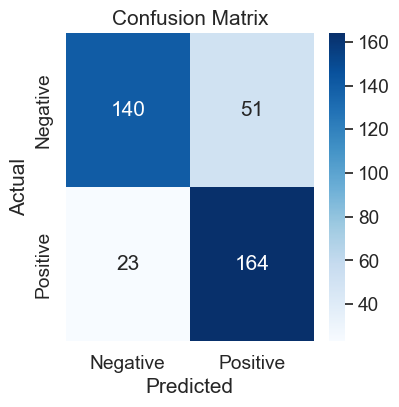

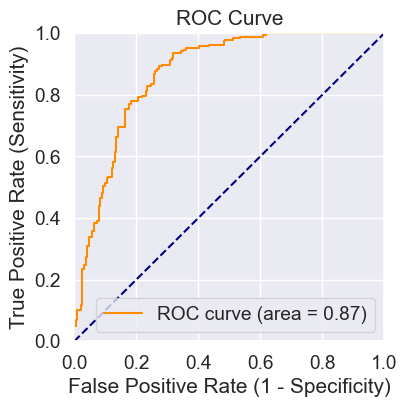

Model Accuracy stored in methodDict: 80.42%


In [43]:
# Logistic Regression Modeli
lr = LogisticRegression()
lr.fit(X_train, y_train) 
y_pred = lr.predict(X_test)  

# Değerlendirme
print('########### Logistic Regression ###############')
metrics_results = evalClassModel(lr, X_test, y_test, y_pred, plot=True)

methodDict['Log. Regres.'] = {key: value * 100 for key, value in metrics_results.items()}  # Tüm metrikleri yüzde olarak ekle
print(f"Model Accuracy stored in methodDict: {methodDict['Log. Regres.']['accuracy']:.2f}%")



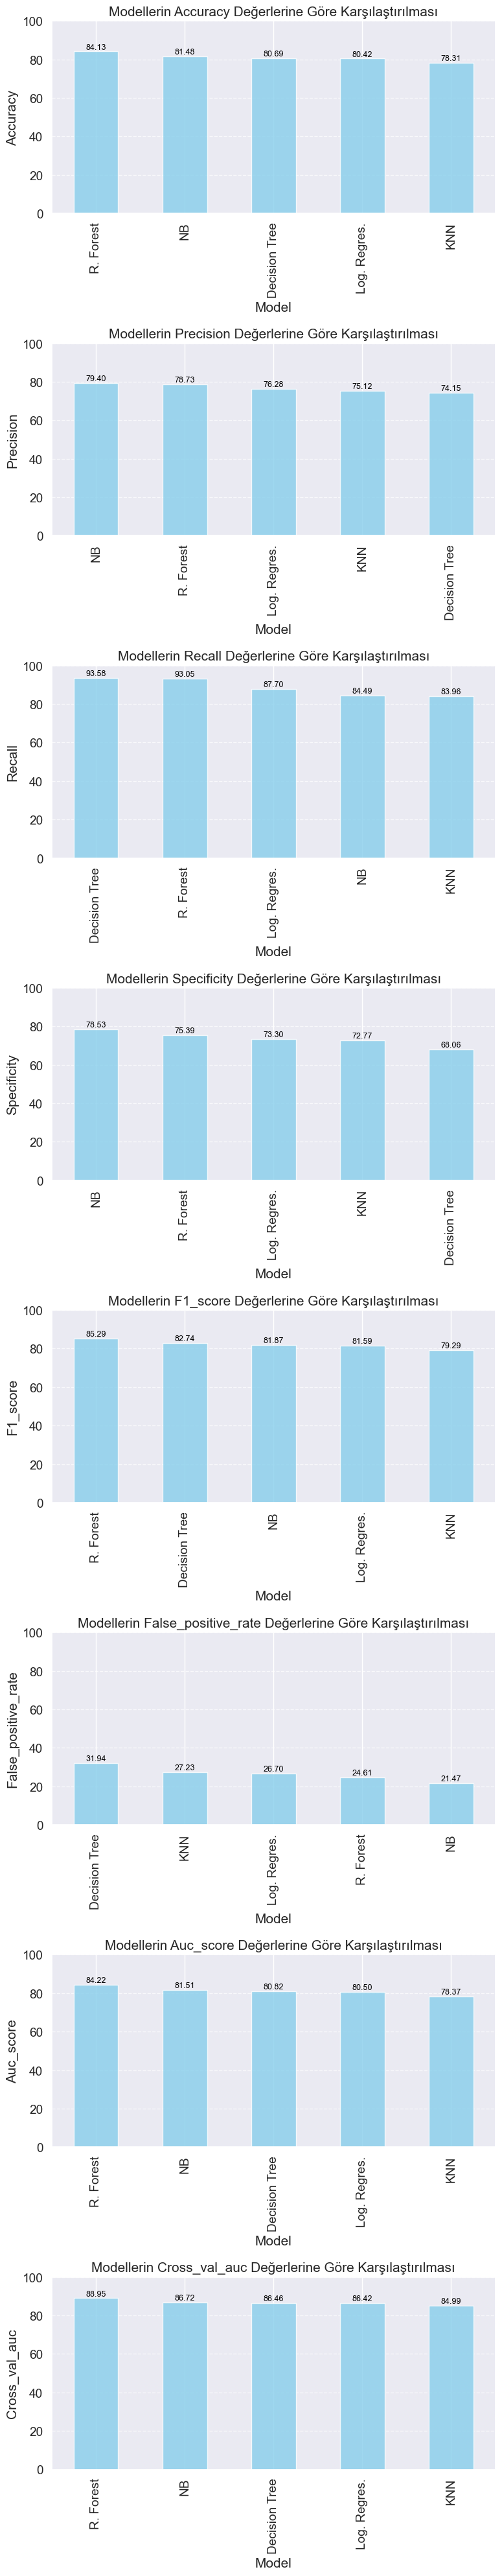

In [45]:
def plotMetrics():

    # methodDict içindeki tüm metrikler için DataFrame oluşturma
    metrics_df = pd.DataFrame(methodDict).T 
    metrics_df.index.name = 'Model'
    metrics_df = metrics_df.reset_index()  

    num_metrics = len(metrics_df.columns) - 1  # İlk sütun 'Model' olduğu için çıkarıyoruz
    fig, axes = plt.subplots(num_metrics, 1, figsize=(8, 5 * num_metrics), squeeze=False)  
    for i, metric in enumerate(metrics_df.columns[1:]): 
        ax = axes[i, 0]  
        sorted_df = metrics_df.sort_values(by=metric, ascending=False)

        sorted_df.plot(
            x='Model', y=metric, kind='bar', legend=False, ax=ax, color='skyblue', alpha=0.8)

        # Çubukların üstüne değer ekleme
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')

        # Grafik düzenlemeleri
        ax.set_ylim([0, 100.0])  # Metrikler yüzde olduğu için ölçeği 0-100
        ax.set_xlabel('Model')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Modellerin {metric.capitalize()} Değerlerine Göre Karşılaştırılması')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout() 
    plt.show()

plotMetrics()